In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy

# Gaussian regression

In [80]:
np.random.seed(123)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0 #1.0

# Generate and plot data
x = 10 * np.random.rand(100)
mu = alpha + beta * x
y = np.random.normal(mu, scale=sigma)

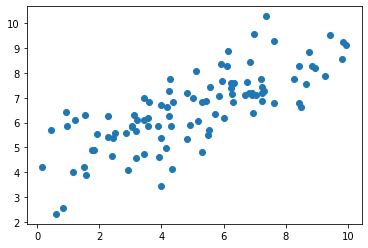

In [81]:
plt.scatter(x, y);

In [82]:
idx = np.argsort(x)
x = x[idx]
y = y[idx]
X = torch.tensor(x[:, None], dtype=torch.float)
Y = torch.tensor(y[:, None], dtype=torch.float)

In [103]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
            
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred

In [104]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(
        f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [105]:
def det_loss(y_pred):
    return torch.square(y_pred - Y).sum()

In [106]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = det_loss(y_pred)
    loss.backward()
    optim.step()

In [107]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1693], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4732], grad_fn=<SliceBackward>) 



---

In [176]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
        self.sigma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred
    
    def log_lik(self, x, y_pred):
        mu = self.alpha + self.beta*x
        sg = self.sigma.exp()
        likelihood = dist.Normal(mu, sg).log_prob(Y)
        return likelihood.sum()
    
    def det_loss(self, x, y_pred):
        return -self.log_lik(x, y_pred) 

In [177]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [178]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = model.det_loss(X, y_pred)
    loss.backward()
    optim.step()

In [179]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1699], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4731], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([-0.0219], grad_fn=<SliceBackward>) 



In [180]:
np.exp(-0.0219)

0.9783380639660794

---

In [2]:
import numpyro

ModuleNotFoundError: No module named 'numpyro'

---

In [13]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        
    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
    
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [14]:
def elbo(y_pred, y, mu, log_var):
    sigma = log_var.exp()**0.5
    # likelihood of observing y given Variational mu and sigma
    likelihood = dist.Normal(mu, sigma).log_prob(y)
    
    # prior probability of y_pred
    log_prior = dist.Normal(0, 1).log_prob(y_pred)
    
    # variational probability of y_pred
    log_p_q = dist.Normal(mu, sigma).log_prob(y_pred) 
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var) 

In [15]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

In [16]:
with torch.no_grad():
    print(torch.abs(m(X)[1] - Y).mean())

tensor(5.7703)


In [17]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

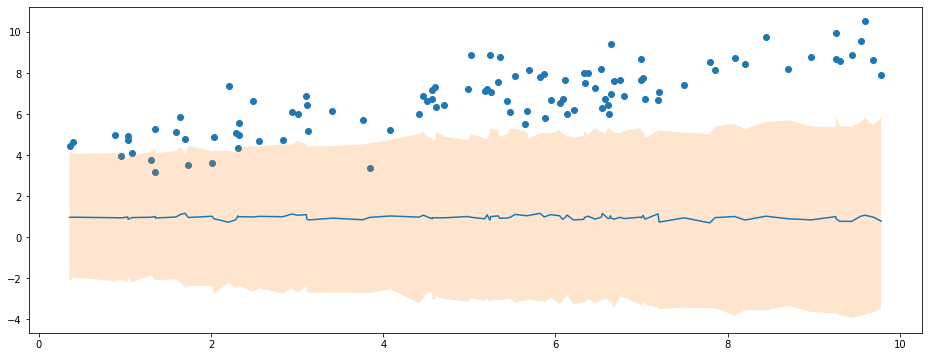

In [18]:
plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [19]:
# # draw samples from Q(theta)
# with torch.no_grad():
#     n = 1000
#     y_pred_sample = np.zeros(n)
#     mu_sample = np.zeros(n)
#     var_sample = np.zeros(n)
#     for i in range(n):
#         y_pred, mu, log_var = m(X)
    
# # Get some quantiles
# q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

# Not for now

In [43]:
# Seed
np.random.seed(123)

# Parameterization
mu = -4

# Number of obs
n_o = 100

shape = n_o 
x = np.random.uniform(0, 100, size=shape)
rd = np.random.random(size=shape)

y = np.zeros(shape=shape, dtype=int)
theta = np.zeros(shape=shape)
theta[:] = mu

rate = np.exp(theta)
exponent = - rate * x
p = np.exp(exponent)
y[:] = p > rd
y

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [44]:
def objective(param):
    
    rate_hat = np.exp(param)
    exponent = - rate_hat * x
    p_hat = np.exp(exponent)
    p_obs = p_hat**y*(1-p_hat)**(1-y)
    return - np.log(p_obs+np.finfo(float).eps).sum()


scipy.optimize.minimize(objective, x0=0)

      fun: 57.71283888084386
 hess_inv: array([[0.0196484]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-3.96093495])